In [1]:
from Bio import SeqIO
import pandas as pd
import numpy as np
import re
from gtfparse import read_gtf
import math
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as pplt
from functools import reduce
import pysam as ps

from sdhb_functions import *

### VEP output

In [7]:
# adjust VEP output file

#ex_sdhb_vep = vep_output('00_Andres_SDHB/exonic_sdhb_bep.txt')
#in_sdhb_vep = vep_output('00_Andres_SDHB/intronic_sdhb_vep.txt')

#pd.DataFrame({'files':[file for file in os.listdir('00_Andres_SDHB/02_vep_results/') 
#                       if file.endswith('.txt')]}).to_csv('00_Andres_SDHB/02_vep_results/vep_dict_list', index=False)

# for all files in 02_vep_results -> run vep_output()
vep_dict = run_all_vep()
all_vars = pd.DataFrame()
for key in vep_dict.keys():
    all_vars = all_vars.append(vep_dict[key])
all_vars = all_vars.sort_values('POS').reset_index(drop=True)

All results already in file "vep_dict.pickle"


### Overview SpliceAI cutoff counts

In [8]:
splai_df = splai_count_df(vep_dict)
splai_spec_df = splai_spec_count_df(vep_dict)

### DataFrames of splice-associated variants

In [9]:
cutoff = 0.25

spl_vars = pd.DataFrame()
for key in vep_dict.keys():
    spl_vars = spl_vars.append(splai_cutoff(cutoff,vep_dict[key])).reset_index(drop=True)

spl_vars = spl_columns(spl_vars, intr_ex_gtf_sdhb)
len(spl_vars)

320

### Negative controls

In [10]:
# every SpliceAI score is 0.0

neg_crtl = pd.DataFrame()
for key in vep_dict.keys():
    neg_crtl = neg_crtl.append(splai_is0(vep_dict[key])).reset_index(drop=True)

neg_crtl = spl_columns(neg_crtl, intr_ex_gtf_sdhb)
len(neg_crtl)

379

In [11]:
# synonymous variants with every SpliceAI score 0.0 and > 5 bp distance from exon-intron boundary
# type in exon
exon_nr = '5'
neg_crtl_sp = neg_crtl[(neg_crtl['intr_ex']==exon_nr)&(neg_crtl['dist_exin']>5)]
neg_crtl_sp[['#CHROM', 'POS', 'REF', 'ALT', 'CADD_PHRED', 'feature', 'intr_ex', 'acc_don', 'dist_exin'
         ]].to_excel(f'00_Andres_SDHB/2022-10-20_splai0_exon{exon_nr}_synonymous.xlsx', index=False)
len(neg_crtl_sp)

14

In [12]:
neg_crtls_dfs = [pd.read_excel(f'00_Andres_SDHB/2022-10-20_splai0_exon{exon_nr}_synonymous.xlsx')
                 for exon_nr in [2,3,4,5]]
comb_neg_ctrls = pd.concat(neg_crtls_dfs, ignore_index=True)

In [13]:
comb_neg_ctrls.to_excel('00_Andres_SDHB/2023-06-02_splai0_exons2345_synonymous.xlsx')

### Distribution of splice-associated variants per gene region

In [14]:
spl_vars['pic_col'] = np.nan
spl_vars['y_pos'] = np.nan

for cutoff,col,y_pos in zip([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], 
                            ['w','w','gray','k','b','g','c', 'y','m','orangered','firebrick'], 
                            [0.42,0.44,0.46,0.48,0.50,0.52,0.54,0.56,0.58,0.6,0.62]):
    spl_vars.loc[((spl_vars['SpliceAI_pred_DS_AG']>=cutoff)|(spl_vars['SpliceAI_pred_DS_AL']>=cutoff)|
                  (spl_vars['SpliceAI_pred_DS_DG']>=cutoff)|(spl_vars['SpliceAI_pred_DS_DL']>=cutoff))&
                 ((spl_vars['SpliceAI_pred_DS_AG']<cutoff+0.1)&(spl_vars['SpliceAI_pred_DS_AL']<cutoff+0.1)&
                  (spl_vars['SpliceAI_pred_DS_DG']<cutoff+0.1)&(spl_vars['SpliceAI_pred_DS_DL']<cutoff+0.1)), 
                 'pic_col']=col
    spl_vars.loc[((spl_vars['SpliceAI_pred_DS_AG']>=cutoff)|(spl_vars['SpliceAI_pred_DS_AL']>=cutoff)|
                  (spl_vars['SpliceAI_pred_DS_DG']>=cutoff)|(spl_vars['SpliceAI_pred_DS_DL']>=cutoff))&
                 ((spl_vars['SpliceAI_pred_DS_AG']<cutoff+0.1)&(spl_vars['SpliceAI_pred_DS_AL']<cutoff+0.1)&
                  (spl_vars['SpliceAI_pred_DS_DG']<cutoff+0.1)&(spl_vars['SpliceAI_pred_DS_DL']<cutoff+0.1)), 
                 'y_pos']=y_pos
spl_vars['y_pos'] = spl_vars['y_pos'].astype(float)

In [15]:
spl_vars[['#CHROM', 'POS', 'REF', 'ALT', 'SpliceAI_pred_DP_AG',
       'SpliceAI_pred_DP_AL', 'SpliceAI_pred_DP_DG', 'SpliceAI_pred_DP_DL',
       'SpliceAI_pred_DS_AG', 'SpliceAI_pred_DS_AL', 'SpliceAI_pred_DS_DG',
       'SpliceAI_pred_DS_DL', 'SpliceAI_pred_SYMBOL', 'MaxEntScan_alt',
       'MaxEntScan_diff', 'MaxEntScan_ref', 'CADD_PHRED', 'feature', 'intr_ex',
       'acc_don', 'dist_exin']].to_excel('00_Andres_SDHB/2022-07-06_splice_variants_o025_intronic500.xlsx', 
                                         index=False)

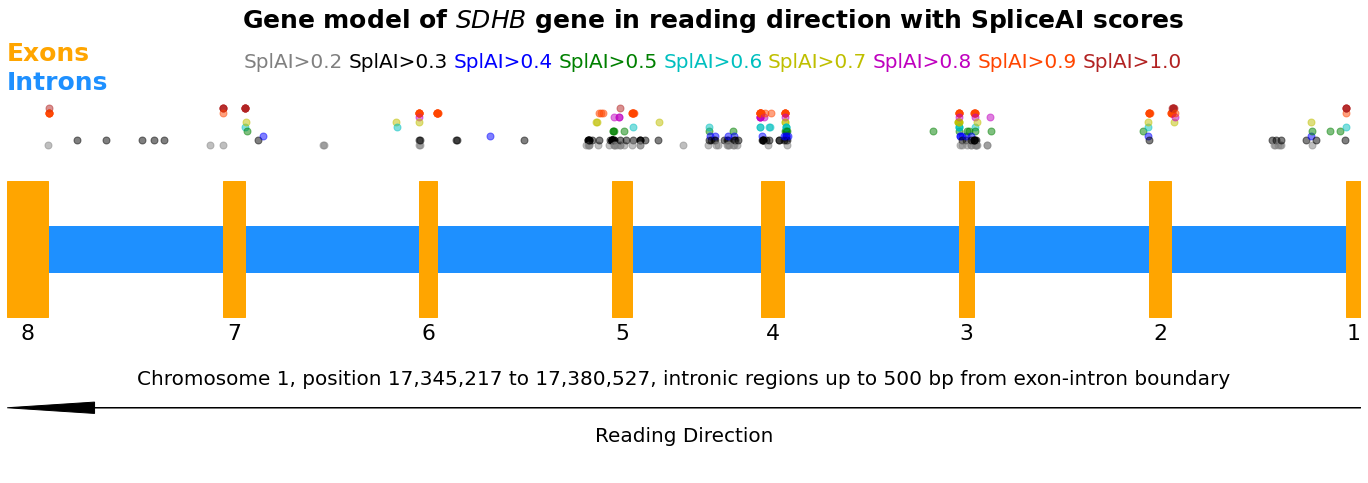

In [16]:
# figure for exons and introns
overview_fig('sdhb', all_vars = all_vars, gtf=intr_ex_gtf_sdhb, splice_vars = spl_vars)

### Distance to splice site and first scatter plots

In [17]:
spl_dist_counts = {}
for df_id in ['exon_acceptor', 'exon_donor', 'intron_acceptor', 'intron_donor']:
    ex_in,acc_don = df_id.split('_')
    df = pd.DataFrame(spl_vars['dist_exin'][(spl_vars['feature']==ex_in)&
                                            (spl_vars['acc_don']==acc_don)].value_counts())
    df = df.reset_index(drop=False).rename(columns={
        'index':'distance_exin', 'dist_exin':'amount'}).sort_values('distance_exin').reset_index(drop=True)
    spl_dist_counts[df_id] = df

In [5]:
#for key in spl_dist_counts.keys():
    #spl_dist_counts[key].plot.scatter(x='distance_exin', y='amount', title=key)

### Merge new SpliceAI results with VEP results

In [ ]:
#make_splai_result_table('01_syn_tables_out/synth_sdhb_vars_spliceai_out.vcf', 
#                        ['exonic_sdhb_vep','intronic_sdhb_vep_100','intronic_sdhb_vep_200','intronic_sdhb_vep_300'],
#                        'vars_splai.pickle')

#make_splai_result_table('01_syn_tables_out/synth_sdhb_vars_last_25_spliceai_out.vcf', 
#                        ['exonic_sdhb_vep','intronic_sdhb_vep_100','intronic_sdhb_vep_200','intronic_sdhb_vep_300',
#                         'intronic_sdhb_vep_400'], 'vars_splai_last_25.pickle')

In [ ]:
splai_300 = pd.read_pickle('vars_splai.pickle')
splai_new_25 = pd.read_pickle('vars_splai_last_25.pickle')
splai_all_325 = splai_300.append(splai_new_25).sort_values('POS', ignore_index=True)

In [26]:
new_vars_025 = splai_all_325[(splai_all_325['DS_AG']>0.25)|(splai_all_325['DS_AL']>0.25)|
                        (splai_all_325['DS_DG']>0.25)|(splai_all_325['DS_DL']>0.25)].copy().reset_index(drop=True)

In [ ]:
old_vars_025 = pd.read_excel('splice_variants_o025_intronic500.xlsx', 
                             dtype={'#CHROM':str, 'POS':int})
old_vars_025 = old_vars_025[(old_vars_025['dist_exin']<=250)&(old_vars_025['intr_ex'].isin([2,3,4]))|
                            ((old_vars_025['feature']=='intron')&(old_vars_025['intr_ex']==1))|
                            ((old_vars_025['feature']=='exon')&(old_vars_025['intr_ex']==5))].copy()

In [ ]:
tog_vars_025 = pd.merge(new_vars_025, old_vars_025[['#CHROM','POS','REF','ALT']], how='left', indicator=True)
tog_vars_025['_merge'] = tog_vars_025['_merge'].replace({'left_only':'new calculation', 
                                                         'right_only':'old calculation'})

tog_vars_025.to_excel('spliceai_variants_o025_intronic325_dist2000_ref_alt.xlsx', 
                      index=False)

### New VEP annotation

- use synthetic variant VCF file (00_Andres_SDHB/01_syn_tables_out/synth_sdhb_vars.vcf)
- to VEP (Variant Effect Predictor)
    - https://grch37.ensembl.org/Homo_sapiens/Tools/VEP

In [31]:
vep_325 = pd.read_table('00_Andres_SDHB/02_vep_results/2023-07-18_new_vars_last_25.txt').drop_duplicates()
vep_325.insert(0, '#CHROM', vep_325['Location'].str.split(':', expand=True)[0].astype(str))
vep_325.insert(1, 'POS', vep_325['Location'].str.split('-', expand=True)[1].astype(int))
vep_325.insert(2, 'REF', vep_325['USED_REF'].copy())
vep_325 = vep_325.rename(columns={'Allele':'ALT', 'CLIN_SIG':'ClinVar'})
vep_325 = vep_325.replace('-', np.nan)
vep_325 = vep_325[vep_325['Feature']=='NM_003000.3']
vep_325 = vep_325.sort_values('PHENOTYPES').drop_duplicates(['Location','ALT']).sort_values(['Location','ALT']
                                                                                           ).reset_index(drop=True)
vep_325 = vep_325[['#CHROM', 'POS', 'REF', 'ALT', 'Consequence', 'IMPACT', 'SYMBOL',
                   'Feature', 'BIOTYPE', 'HGVSc', 'HGVSp', 'cDNA_position', 'CDS_position',
                   'Protein_position', 'Amino_acids', 'Codons', 'Existing_variation',
                   'STRAND', 'SIFT', 'PolyPhen', 'AF', 'gnomADe_AF', 'ClinVar', 'SOMATIC',
                   'PHENO', 'PUBMED', 'PHENOTYPES', 'NMD']].copy()

In [32]:
vep_txt = pd.read_table('00_Andres_SDHB/02_vep_results/2023-06-26_new_vars_vep.txt').drop_duplicates()

vep_txt.insert(0, '#CHROM', vep_txt['Location'].str.split(':', expand=True)[0].astype(str))
vep_txt.insert(1, 'POS', vep_txt['Location'].str.split('-', expand=True)[1].astype(int))
vep_txt.insert(2, 'REF', vep_txt['USED_REF'].copy())
vep_txt = vep_txt.rename(columns={'Allele':'ALT', 'CLIN_SIG':'ClinVar'})
vep_txt = vep_txt.replace('-', np.nan)
vep_txt = vep_txt[vep_txt['Feature']=='NM_003000.3']
vep_txt = vep_txt.sort_values('PHENOTYPES').drop_duplicates(['Location','ALT']).sort_values(['Location','ALT']
                                                                                           ).reset_index(drop=True)
vep_txt = vep_txt[['#CHROM', 'POS', 'REF', 'ALT', 'Consequence', 'IMPACT', 'SYMBOL',
                   'Feature', 'BIOTYPE', 'HGVSc', 'HGVSp', 'cDNA_position', 'CDS_position',
                   'Protein_position', 'Amino_acids', 'Codons', 'Existing_variation',
                   'STRAND', 'SIFT', 'PolyPhen', 'AF', 'gnomADe_AF', 'ClinVar', 'SOMATIC',
                   'PHENO', 'PUBMED', 'PHENOTYPES', 'NMD']]
vep_all_325 = vep_txt.append(vep_325).sort_values('POS', ignore_index=True)

/software/miniconda3/envs/Alexandra_DEV/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [34]:
clinv_dict = {
    'benign/likely_benign,conflicting_interpretations_of_pathogenicity,uncertain_significance,benign,likely_benign':'benign,likely_benign,uncertain_significance',
    'uncertain_significance,pathogenic':'pathogenic,uncertain_significance',
    'pathogenic,likely_pathogenic':'pathogenic,likely_pathogenic',
    'uncertain_significance,benign,likely_benign,benign/likely_benign':'benign,likely_benign,uncertain_significance',
    'likely_benign,uncertain_significance':'likely_benign,uncertain_significance',
    'pathogenic,pathogenic/likely_pathogenic,likely_pathogenic':'pathogenic,likely_pathogenic',
    'uncertain_significance,likely_pathogenic':'likely_pathogenic,uncertain_significance',
    'likely_pathogenic,pathogenic':'pathogenic,likely_pathogenic',
    'pathogenic/likely_pathogenic,likely_pathogenic,pathogenic':'pathogenic,likely_pathogenic',
    'uncertain_significance,not_provided':'uncertain_significance',
    'benign/likely_benign,benign,likely_benign':'benign,likely_benign',
    'uncertain_significance,pathogenic,likely_pathogenic':'pathogenic,likely_pathogenic,uncertain_significance',
    'likely_pathogenic,uncertain_significance':'likely_pathogenic,uncertain_significance',
    'uncertain_significance,likely_benign':'likely_benign,uncertain_significance',
    'uncertain_significance,likely_pathogenic,pathogenic':'pathogenic,likely_pathogenic,uncertain_significance',
    'benign,uncertain_significance,likely_benign':'benign,likely_benign,uncertain_significance',
    'benign,not_provided,likely_benign':'benign,likely_benign',
    'pathogenic/likely_pathogenic,pathogenic,likely_pathogenic':'pathogenic,likely_pathogenic',
    'benign,uncertain_significance':'benign,uncertain_significance'}

In [35]:
vep_all_325['ClinVar'] = vep_all_325['ClinVar'].replace(clinv_dict)

In [36]:
clinv_simple_dict = {
    'likely_pathogenic':'pathogenic,likely_pathogenic', 
    'pathogenic':'pathogenic,likely_pathogenic',
    'likely_benign':'benign,likely_benign', 
    'benign,likely_benign,uncertain_significance':'benign,likely_benign',
    'pathogenic,uncertain_significance':'pathogenic,likely_pathogenic',
    'pathogenic,likely_pathogenic':'pathogenic,likely_pathogenic',
    'likely_benign,uncertain_significance':'benign,likely_benign',
    'likely_pathogenic,uncertain_significance':'pathogenic,likely_pathogenic', 
    'benign,likely_benign':'benign,likely_benign',
    'pathogenic,likely_pathogenic,uncertain_significance':'pathogenic,likely_pathogenic', 
    'benign':'benign,likely_benign',
    'benign,uncertain_significance':'benign,likely_benign'
}

In [37]:
vep_all_325['ClinVar_simple'] = vep_all_325['ClinVar'].replace(clinv_simple_dict)

In [ ]:
all_vars = pd.merge(splai_all_325, vep_all_325, on=['#CHROM','POS','REF','ALT'])
all_vars.to_excel('all_variants_exins_2345_dist325.xlsx', index=False)

In [ ]:
all_vars_o25 = all_vars[(all_vars['DS_AG']>0.25)|(all_vars['DS_AL']>0.25)|
                        (all_vars['DS_DG']>0.25)|(all_vars['DS_DL']>0.25)].copy().reset_index(drop=True)
all_vars_o25.to_excel('all_variants_exins_2345_dist325_spliceai025.xlsx', index=False)